In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (precision_recall_fscore_support,precision_score, recall_score, 
                           confusion_matrix, accuracy_score,
                           f1_score, balanced_accuracy_score,
                           matthews_corrcoef,confusion_matrix)
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import glob

df1 = pd.read_csv("dataset/Physical dataset/phy_att_1.csv", sep="\t", encoding="utf-16")
df2 = pd.read_csv("dataset/Physical dataset/phy_att_2.csv", sep="\t", encoding="utf-16")
df3 = pd.read_csv("dataset/Physical dataset/phy_att_3.csv", sep="\t", encoding="utf-16")

df1.drop("Label_n",inplace=True,axis=1)
df2.drop("Lable_n",inplace=True,axis=1)
df3.drop("Label_n",inplace=True,axis=1)

# merge all datasets vertically
df = pd.concat([df1, df2, df3], axis=0)
df.drop("Time", inplace=True, axis=1)

# replace 'nomal' column to 'normal'
df["Label"] = df["Label"].apply(lambda x: "normal" if x == "nomal" else x)

# drop lines where label is "scan"
# df = df[df["Label"] != "scan"]

In [2]:
# 1 if Label is not 'normal' else 0

df["Label_n"] = df["Label"].apply(lambda x: 1 if x != "normal" else 0)

# shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,Tank_1,Tank_2,Tank_3,Tank_4,Tank_5,Tank_6,Tank_7,Tank_8,Pump_1,Pump_2,...,Valv_15,Valv_16,Valv_17,Valv_18,Valv_19,Valv_20,Valv_21,Valv_22,Label,Label_n
0,1058,1429,656,255,787,29,0,0,False,False,...,False,False,True,True,False,True,False,False,normal,0
1,231,1442,38,328,557,247,0,30,False,False,...,True,False,True,True,False,True,False,True,normal,0
2,537,1734,290,363,831,0,0,288,False,False,...,False,False,True,True,False,True,False,True,physical fault,1
3,3,4,338,332,245,391,184,0,False,False,...,True,False,False,False,False,True,False,False,normal,0
4,1604,1666,494,28,455,0,313,493,False,False,...,False,False,True,False,False,False,False,True,normal,0


In [3]:
# print the number of different values for each column
# print only the cols with 1 unique value
print(df.nunique()[df.nunique() == 1])

# remove the cols with 1 unique value
df.drop(columns=df.nunique()[df.nunique() == 1].index, inplace=True)


Pump_3           1
Flow_sensor_3    1
Valv_1           1
Valv_2           1
Valv_3           1
Valv_4           1
Valv_5           1
Valv_6           1
Valv_7           1
Valv_8           1
Valv_9           1
Valv_16          1
Valv_19          1
Valv_21          1
dtype: int64


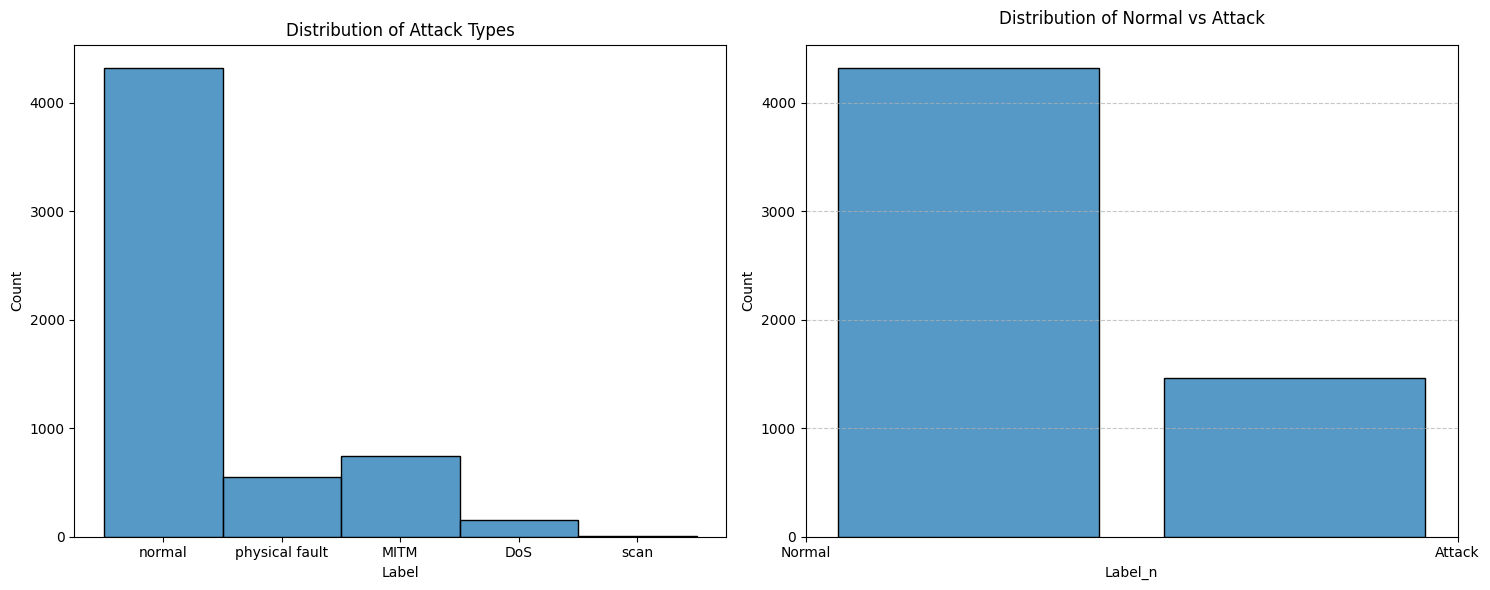

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Label distribution
sns.histplot(data=df, x='Label', ax=ax1)
ax1.set_title('Distribution of Attack Types')

# Plot Label_n distribution with improved style
sns.histplot(data=df, x='Label_n', ax=ax2, bins=2, stat='count', 
             shrink=0.8, edgecolor='black')
ax2.set_title('Distribution of Normal vs Attack', pad=15, fontsize=12)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Normal', 'Attack'], fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [5]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import time
from pprint import pprint

# Prepare data
target = "Label"
X = df.drop(["Label", "Label_n"], axis=1)
y = df[target]

possible_outputs = df[target].unique()

# Define models to test
models = {
    'KNN': KNeighborsClassifier(n_neighbors=10),
    # 'CART': DecisionTreeClassifier(random_state=15),
    # 'Random Forest': RandomForestClassifier(random_state=15, n_estimators=100),
    # 'XGBoost': XGBClassifier(random_state=15),
    # 'CatBoost': CatBoostClassifier(random_state=15, verbose=False),
    # "SVM": SVC(random_state=15, kernel="rbf"),
    # "Naive Bayes": GaussianNB()
}

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=15)

for model_name, model in models.items():
    # Initialize lists to store metrics
    metrics = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    start = time.time()
    
    # Perform k-fold cross validation
    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train and evaluate model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        report = classification_report(y_test, y_pred, output_dict=True)
        pprint(report)
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(report['macro avg']['precision'])
        metrics['recall'].append(report['macro avg']['recall'])
        metrics['f1'].append(report['macro avg']['f1-score'])

    # Print results
    print(f"\nModel: {model_name} ran on {len(metrics['accuracy'])} folds in {time.time() - start:.2f} seconds")
    for metric in metrics:
        print(f'Average {metric.title()}(macro avg): {np.mean(metrics[metric]):.2f} ± {np.std(metrics[metric]):.2f}')

c:\Programmation\School\TPS\Entreposage et protection des données massives\projet-entreposage\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programmation\School\TPS\Entreposage et protection des données massives\projet-entreposage\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programmation\School\TPS\Entreposage et protection des données massives\projet-entreposage\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

{'DoS': {'f1-score': 0.9230769230769231,
         'precision': 0.8571428571428571,
         'recall': 1.0,
         'support': 30.0},
 'MITM': {'f1-score': 0.9114754098360656,
          'precision': 0.879746835443038,
          'recall': 0.9455782312925171,
          'support': 147.0},
 'accuracy': 0.9610726643598616,
 'macro avg': {'f1-score': 0.7515680818584372,
               'precision': 0.7423838838203894,
               'recall': 0.7643996847453888,
               'support': 1156.0},
 'normal': {'f1-score': 0.9738717339667459,
            'precision': 0.9750297265160524,
            'recall': 0.9727164887307236,
            'support': 843.0},
 'physical fault': {'f1-score': 0.9494163424124513,
                    'precision': 1.0,
                    'recall': 0.9037037037037037,
                    'support': 135.0},
 'scan': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 1.0},
 'weighted avg': {'f1-score': 0.9609206495656203,
                  'precision': 0.9619

c:\Programmation\School\TPS\Entreposage et protection des données massives\projet-entreposage\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programmation\School\TPS\Entreposage et protection des données massives\projet-entreposage\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programmation\School\TPS\Entreposage et protection des données massives\projet-entreposage\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

{'DoS': {'f1-score': 0.8852459016393442,
         'precision': 0.84375,
         'recall': 0.9310344827586207,
         'support': 29.0},
 'MITM': {'f1-score': 0.8896321070234113,
          'precision': 0.8866666666666667,
          'recall': 0.8926174496644296,
          'support': 149.0},
 'accuracy': 0.9576124567474048,
 'macro avg': {'f1-score': 0.743072220090039,
               'precision': 0.7366859869719082,
               'recall': 0.7503900111844106,
               'support': 1156.0},
 'normal': {'f1-score': 0.9715942028985507,
            'precision': 0.9710312862108922,
            'recall': 0.9721577726218097,
            'support': 862.0},
 'physical fault': {'f1-score': 0.9688888888888889,
                    'precision': 0.9819819819819819,
                    'recall': 0.956140350877193,
                    'support': 114.0},
 'scan': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 2.0},
 'weighted avg': {'f1-score': 0.9569159613545963,
                  '

c:\Programmation\School\TPS\Entreposage et protection des données massives\projet-entreposage\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programmation\School\TPS\Entreposage et protection des données massives\projet-entreposage\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programmation\School\TPS\Entreposage et protection des données massives\projet-entreposage\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

{'DoS': {'f1-score': 0.8571428571428571,
         'precision': 0.7714285714285715,
         'recall': 0.9642857142857143,
         'support': 28.0},
 'MITM': {'f1-score': 0.9448275862068966,
          'precision': 0.9072847682119205,
          'recall': 0.9856115107913669,
          'support': 139.0},
 'accuracy': 0.9714532871972318,
 'macro avg': {'f1-score': 0.7489451571104597,
               'precision': 0.731202366959226,
               'recall': 0.7719365544044954,
               'support': 1156.0},
 'normal': {'f1-score': 0.9814293753517164,
            'precision': 0.9886621315192744,
            'recall': 0.9743016759776536,
            'support': 895.0},
 'physical fault': {'f1-score': 0.9613259668508287,
                    'precision': 0.9886363636363636,
                    'recall': 0.9354838709677419,
                    'support': 93.0},
 'scan': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 1.0},
 'weighted avg': {'f1-score': 0.9715515919893356,
        

c:\Programmation\School\TPS\Entreposage et protection des données massives\projet-entreposage\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programmation\School\TPS\Entreposage et protection des données massives\projet-entreposage\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programmation\School\TPS\Entreposage et protection des données massives\projet-entreposage\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an